# Probabilistic Linear Discriminant Analysis

It is called generative model because the model generates x (the sample of an specific class)

Motivations

refs: https://ravisoji.com/assets/papers/Ioffe2006PLDA.pdf (abstract)

1. Fisher LDA is common used in object recognition for feature extraction, but do not address the problem of how to use these features for recognition.
2. latent variables of PLDA (PLDA components) represent both: the class of the object and the within variability  variability class of the object.
3. Automatic give more wieght of the features with the most discriminativy power
4. Can build a model of unseen class with only one example or  can combine multiple examples for a better representation of the class



Assumptions of PLDA:

1. All classes are normal distributed: $P(x \mid y) = N(x \mid y,\Phi_w)$
     where y is label
2. All class has the same covariance matrix $\Phi_w$
3. n_k = n const: Each class has the same number of samples. Case it is not true, resample the class in order to have all class with the same number of observations

The solution has the constraints:
1. $\Phi_w$ is positive defined
2. The priori $P(y) = N(y \mid 0,\Phi_b)$ is normal distributed
3. $\Phi_b$ is semi-positive defined

Application:

* Speaker recognition
* Face recogintion

We show applications to classification, hypothesis testing,
class inference, and clustering, on classes not observed during training.

###  Small discussion about how LDA works (Can be skipped)

The goal of (PLDA) is to find best new set of axis that maximizes the distance between the means of the classes and also minimize overlap between the projected classes (confusion region). 

The figures below describe LDA being applied to a bidimensional dataset containing 2 classes. 

The dataset is a set of $n$ d-dimensional samples $X = \{x_1, x_2, ..., x_n\}$ already labeled in 2 groups: 
$X^{(k)} = \{ x_1^{(k)},  x_2^{(k)}, ..., x_{n_k}^{(k)} \}$ of size $n_k$ for $k = 1,2$ where $x_i^{(k)}$ is a vector of dimension $d$.


In order to do that, Fisher proposed to maximize the ratio "scattter between classes/scatter within classes" that is expressed by the Cost function:

$
J(v) = \frac{v^t S_{b} v}{ v^t S_{v}  v}
$

where:

* $S_b= \sum_1^2 (m_2 - m)( m_2 - m)^t$ :  between-class covariance/satter matrix. (Can be understood as measure of between class spread)
    
* $S_{w} =  S_1 + S_2$ : within-class covariance/scatter matrices. (Can be understood as measure of within class spread or the sum of the spread matrix of each class) 

$ m_1$ and $ m_2$ are the mean of each class. $S_1$ and $S_2$ are the apread matrix of each class. $m$ is the global mean.

$
S_k = \sum_{x_i\in X^{(k)}} ( x_i^{(k)} -  m_k) ( x_i^{(k)} - m_k)^t  
$

The spread matrix are related to the covariance matrx by the equation:


$
\Sigma_k = \frac{1}{N_k -1}S_k  
$


The total scatter is given by:

$
S_t = S_W + S_B
$

But can also be expressed as:

$
S_t = \sum_{j=1}^{n}(x_j - m)(x_j - m)^t \equiv \sum_{k=1}^2 \sum_{i=1}^{n_k}(x_i^{(k)} - m)(x_i^{(k)} - m)^t = S_w + S_b
$

$
n = \sum_{k=1}^2 n_k
$

Can be proved in  [here](refs/ea71fbef3b55b69e142897fadf43b3269463.pdf) and [here](refs/Dimensionality2.pdf) that maximize $J(v)$ is equivalent to find the solution of the eigenvalue problem for the matrix:

$
A =  S_{w}^{-1} S_b
$

$
A{v} =  \lambda {v}
$

where:
* $v$ is the eigenvector and define the new axes
* $\lambda$ is the eigenvalue

### Summarizing the LDA approach in 5 steps

1. Compute Fisher LDA parameters 
2. Update parameters 
    * between-class: measure of dispersion between groups or classes
    * within-class scatter matrix: measure of dispersion in the class or group
3. Reduce dimensionality



In [1]:
import numpy as np
import pandas as pd
import random as rand
import math
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA as sklearnPCA

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

load data

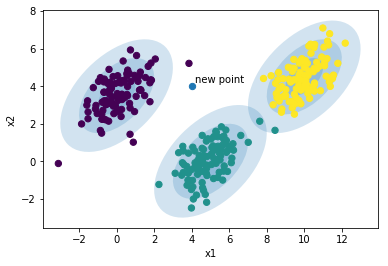

array([[-0.6792,  3.6821],
       [ 0.2821,  3.5759],
       [-0.2309,  3.4317],
       [ 0.2598,  4.2917],
       [-0.2967,  3.9267]])

array([[-0.6792,  3.6821],
       [ 0.2821,  3.5759],
       [-0.2309,  3.4317],
       [ 0.2598,  4.2917],
       [-0.2967,  3.9267]])

,label,x,y
297,3,9.742593,4.417351
211,3,9.359564,2.848714
250,3,9.352474,3.178991
258,3,9.993574,4.596626
39,1,-0.006610,2.635281


In [16]:
%run ../simulated_plda_data.ipynb

X = df[['x','y']].values
N = X.shape[0]
y = df.label

X1 = df.loc[df.label ==1,['x','y']].values
nk = X1.shape[0]

X1[:5]

X1l = np.squeeze(X[np.argwhere(y == 1)])

X1l[:5]

df.sample(5).head(5)

In [74]:
def estimate_gaussian_parameters(Xk):

    mk = np.mean(Xk,axis=0)
    Sk = np.cov(Xk[:,0],Xk[:,1])
    return mk, Sk

def get_plda_paramaters(Xk,N):
    
    Nk = Xk.shape[0]
    
    pik = Nk/N
    
    mk, Sk = estimate_gaussian_parameters(Xk)
    
    Sk_inv = np.linalg.inv(Sk)
    
    return Sk_inv, pik

def lda_score(X_new,mk, Sk,Sk_inv, pik):
    
    scorek = -0.2*np.log(np.linalg.det(Sk)) 
    uk = X_new - mk
    Ak = np.matmul(Sk_inv,uk.T)
    scorek = scorek - 0.5*np.matmul(uk,Ak) 
    scorek += np.log(pik)
    
    return scorek

def compute_scatter_matrixes(X,y,nk):
    
    d = X.shape[1]
    m = np.mean(X,axis=0)
    
    Sw = np.zeros((d,d))
    Sb = np.zeros((d,d))
    
    for label in y:
        
        Xk = np.squeeze(X[np.argwhere(y == label)])
        mk, Sk = estimate_gaussian_parameters(Xk)
        
        # within spread matrix
        Sw = np.add(Sw,Sk)
        
        # between spread matrix
        dmk = (np.add(mk,-m))
        dmk = dmk[np.newaxis].transpose()

        Sb = np.add(Sb, nk*np.dot(dmk, dmk.transpose()))

    return Sw, Sb
    
def diagnolize_matrix(M, W):
    
    M_diag = np.matmul(W.transpose(),np.matmul(M,W))
    M_diag = np.diag(M_diag.diagonal())
    
    return M_diag
    
def compute_transformation_matrix(Sw,Sb,nk):
    
    Sw_inv = np.linalg.inv(Sw)
    d = Sw.shape[0]
     
    S = np.matmul(Sw_inv, Sb)
    eigen_values, W = np.linalg.eig(S)
        
    # projected/diagnolized within spread matrix: projecting Sw
    Lambda_w = diagnolize_matrix(Sw,W)
  
    weight = nk/(nk - 1.0)
    
    Lambda_w_weighted = weight*Lambda_w  
    Lambda_w_weighted[np.isclose(Lambda_w_weighted, 0.0)] = 0.0
    
    Lambda_w_weighted = np.sqrt(Lambda_w_weighted)
    
    W_transposed_inv = np.linalg.inv(W.T)
    
    A = np.matmul(W_transposed_inv, Lambda_w_weighted)
    
    return A, W



def compute_transformed_between_covariance(Lambda_w,Lambda_b,nk):
    
    weight = (nk - 1)/nk
    
    with np.errstate(divide='ignore', invalid='ignore'):
         Psi = weight * Lambda_b / Lambda_w

    Psi[np.isnan(Psi)] = 0.0
    Psi = Psi -1.0/nk
    
    # max(0, Psi)
    Psi[Psi < 0] = 0.0
    
    Psi[np.isinf(Psi)] = 0
    Psi = np.diag(Psi.diagonal())

    return Psi


def plda_fit(X, labels):
   
    N = X.shape[0]
    K = labels.nunique()
    nk = N/K
    
    global_mean = np.mean(X)
    
    S_w, S_b = compute_scatter_matrixes(X,labels,nk)
    
    A, W = compute_transformation_matrix(Sw,Sb,nk)
    
    Lambda_w = diagnolize_matrix(Sw,W)
    Lambda_b = diagnolize_matrix(Sb,W)
    
    # The withiin trasnformed covariance is Identity matrix
    Psi = compute_transformed_between_covariance(Lambda_w,Lambda_b,nk)
   
    return global_mean, A, Psi

def project_data(z):
    
    z_tranformed = np.matmul(A_inv,z - global_mean)
    
    return z_tranformed

def plda_predict(x_new):
    
    # u' = A^{-1}(x - m)
    u_new = project_data(x_new)
    
    for y in labels:
        
        u_avg = comp
        score = _compute_posterior_probability()
        
    return score

In [75]:
Sw,Sb = compute_scatter_matrixes(X,y,nk)

Sw

Sb


array([[277.3866, 154.0639],
       [154.0639, 296.437 ]])

array([[483259.8762,  47219.6191],
       [ 47219.6191, 108036.2443]])

In [76]:
A, W = compute_transformation_matrix(Sw,Sb, nk)
A
W

array([[13.948 ,  9.2543],
       [-0.3219, 17.3011]])

array([[ 0.8818,  0.0231],
       [-0.4717,  0.9997]])

In [77]:
Lambda_w = diagnolize_matrix(Sw,W)
Lambda_b = diagnolize_matrix(Sb,W)

Psi = compute_transformed_between_covariance(Lambda_w,Lambda_b,nk)

print('Lambdas')
Lambda_w
Lambda_b

Phi_w = np.matmul(A,A.T)
Phi_b = np.matmul(A,np.matmul(Psi,A.T))

print('Phis')
Phi_w
Phi_b

Psi

Lambdas


array([[153.474 ,   0.    ],
       [  0.    , 303.5332]])

array([[360508.7221,      0.    ],
       [     0.    , 110413.9963]])

Phis


array([[280.1885, 155.6201],
       [155.6201, 299.4313]])

array([[483257.0743,  47218.0629],
       [ 47218.0629, 108033.25  ]])

array([[2325.4897,    0.    ],
       [   0.    ,  360.1149]])

In [78]:
m, A, Psi = plda_fit(X, y)

m
A
Psi


3.8293604070909564

array([[13.948 ,  9.2543],
       [-0.3219, 17.3011]])

array([[2325.4897,    0.    ],
       [   0.    ,  360.1149]])

In [92]:
## double check transformations

u1 = np.matmul(W.T,x_new)

A_inv = np.linalg.inv(A)

u2 = np.matmul(A_inv,x_new - m)

np.dot(u1,u2)

np.matmul(u1,u2.T)

# u1 n u2 are orthogonal


np.arccos(np.matmul(u1,u2.T))/np.pi

0.049999786202823825

0.049999786202823825

0.48407793490232115

In [105]:
St = (N - 1.0)* np.cov(X[:,0],X[:,1])

u = np.add(X,-m).transpose()
S_hat = np.matmul(u,u.transpose())

St - S_hat

Sw + Sb

St

S_hat

array([[-391.2412,  391.2412],
       [ 391.2412, -391.2412]])

array([[483537.2628,  47373.6829],
       [ 47373.6829, 108332.6813]])

array([[5107.2115,  624.7194],
       [ 624.7194, 1373.835 ]])

array([[5498.4527,  233.4782],
       [ 233.4782, 1765.0762]])

## Verification of the equations on the first sections

For the verification of the formulas cited in the firsts sections (See: [Small discussion about how LDA works (Can be skipped)]()), we are going to compute all matrix: $\hat{\Sigma_1}$, $\hat{\Sigma_2}$ and $S_t$ and compare with the global covariance matrix of the data (the spread of the data conserves) $\hat{\Sigma}$. Also because we generated the data using two multivariate Gaussians, we know the true values of the parameters $\Sigma_1$ and $\Sigma_2$ and we can compare with our estimations of this parameters.

* Estimating the covariances Matrix

Computing $\hat{\Sigma_k}$ and comparing with the true values $\Sigma_k$


In [ ]:
plot_pca(X_pca,title='PCA via scikit-learn')
plot_lda(X_lda, title='LDA via scikit-learn')

LDA gave us a better separated classes: Versicolor and Virginica.